# Section 1 performance Metrrics

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load the dataset
file_path = 'app_logs.xlsx'
app_logs_data = pd.ExcelFile(file_path)
app_logs_df = app_logs_data.parse('app_logs')

In [41]:
app_logs_df.head()

,timestamp,endpoint,user_id,response_time_ms,status_code
0,2024-12-01 23:20:31,/api/search,user_25,98,200
1,2024-12-01 23:25:31,/api/recommendations,user_82,107,200
2,2024-12-01 23:30:31,/api/chat,user_89,147,200
3,2024-12-01 23:35:31,/api/search,user_12,96,200
4,2024-12-01 23:40:31,/api/search,user_15,98,200


In [42]:
print(app_logs_df['status_code'].unique())
print(app_logs_df['endpoint'].unique())

[200 500 504 400]
['/api/search' '/api/recommendations' '/api/chat' '/api/user/profile']


In [43]:
app_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         2016 non-null   datetime64[ns]
 1   endpoint          2016 non-null   object        
 2   user_id           2016 non-null   object        
 3   response_time_ms  2016 non-null   int64         
 4   status_code       2016 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 78.9+ KB


In [44]:
app_logs_df.describe()

,timestamp,response_time_ms,status_code
count,2016,2016.000000,2016.000000
mean,2024-12-05 11:18:01,419.240575,215.714286
min,2024-12-01 23:20:31,70.000000,200.000000
25%,2024-12-03 17:19:16,97.000000,200.000000
50%,2024-12-05 11:18:01,117.000000,200.000000
75%,2024-12-07 05:16:46,145.000000,200.000000
max,2024-12-08 23:15:31,30000.000000,504.000000
std,NaN,2961.986796,63.129672


In [45]:
# Convert timestamp to datetime
app_logs_df['timestamp'] = pd.to_datetime(app_logs_df['timestamp'])

# 1. Calculate Performance Metrics
grouped = app_logs_df.groupby('endpoint')

# Average and p95 response times
metrics_df = grouped['response_time_ms'].agg(
    avg_response_time=('mean'),
    p95_response_time=lambda x: x.quantile(0.95)
).reset_index()

In [46]:
metrics_df

,endpoint,avg_response_time,p95_response_time
0,/api/chat,445.026515,235.65
1,/api/recommendations,348.311871,155.20
2,/api/search,471.608081,157.90
3,/api/user/profile,410.600806,160.00


In [47]:
# Error rates
error_counts = app_logs_df[app_logs_df['status_code'] != 200].groupby('endpoint').size()
total_counts = grouped.size()
error_rates = (error_counts / total_counts).fillna(0).reset_index(name='error_rate')

In [48]:
# Percentage of slow requests
slow_requests = grouped['response_time_ms'].apply(lambda x: (x > 1000).mean()).reset_index(name='%_slow_requests')

In [49]:
slow_requests

,endpoint,%_slow_requests
0,/api/chat,0.009470
1,/api/recommendations,0.008048
2,/api/search,0.012121
3,/api/user/profile,0.010081


In [50]:
# Merge metrics
metrics_df = metrics_df.merge(error_rates, on='endpoint', how='left')
metrics_df = metrics_df.merge(slow_requests, on='endpoint', how='left')

In [51]:
# Peak usage periods
usage_by_time = app_logs_df.set_index('timestamp').resample('1H').size().reset_index(name='request_count')

<ipython-input-51-dcea81753818>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  usage_by_time = app_logs_df.set_index('timestamp').resample('1H').size().reset_index(name='request_count')


# Section 2 Visualization Dashboard

<ipython-input-52-2259acbdf10f>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = data.set_index('timestamp').resample('1H')['response_time_ms'].mean()


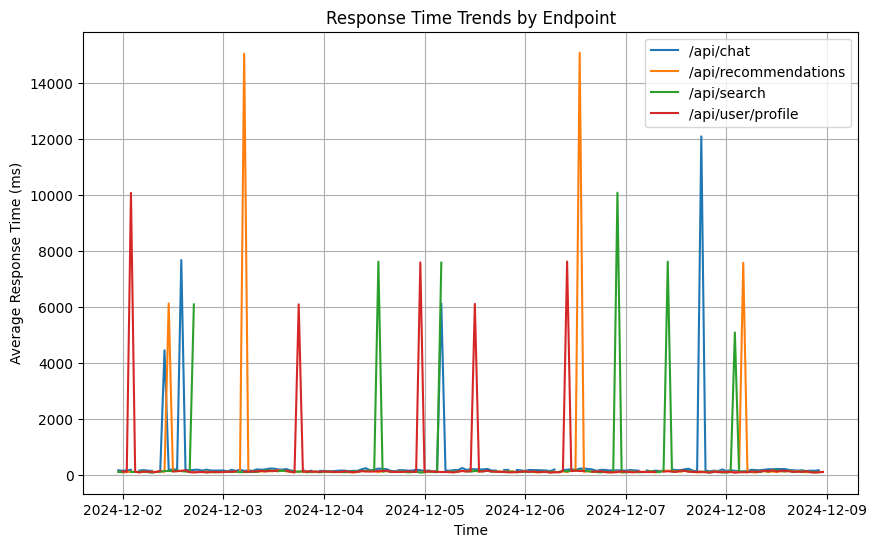

In [52]:
# Response Time Trends
plt.figure(figsize=(10, 6))
for endpoint, data in app_logs_df.groupby('endpoint'):
    resampled = data.set_index('timestamp').resample('1H')['response_time_ms'].mean()
    plt.plot(resampled.index, resampled.values, label=endpoint)
plt.title('Response Time Trends by Endpoint')
plt.xlabel('Time')
plt.ylabel('Average Response Time (ms)')
plt.legend()
plt.grid(True)
plt.show()

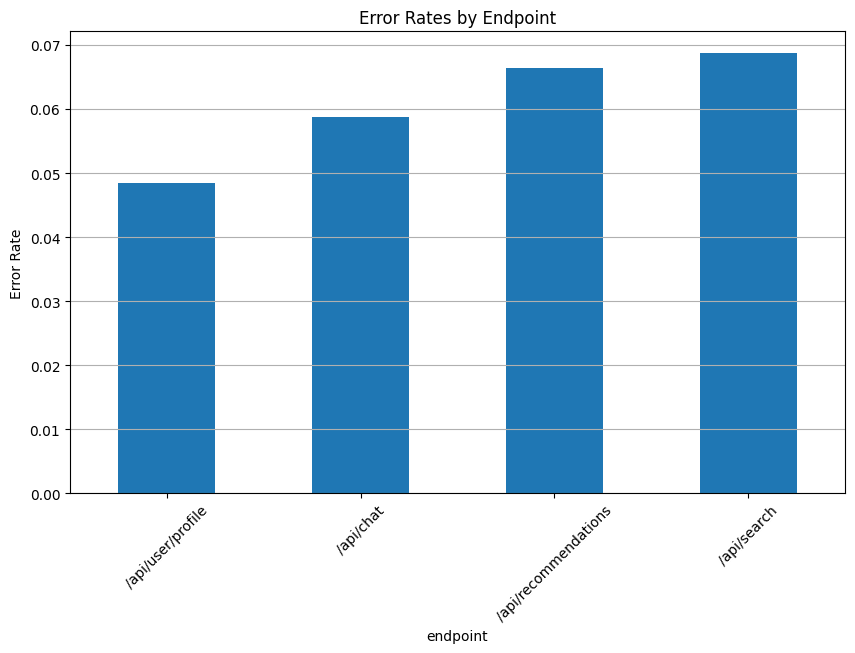

In [53]:
# Error Rate Patterns
error_rates_plot = metrics_df[['endpoint', 'error_rate']].set_index('endpoint').sort_values(by='error_rate')
error_rates_plot.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Error Rates by Endpoint')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

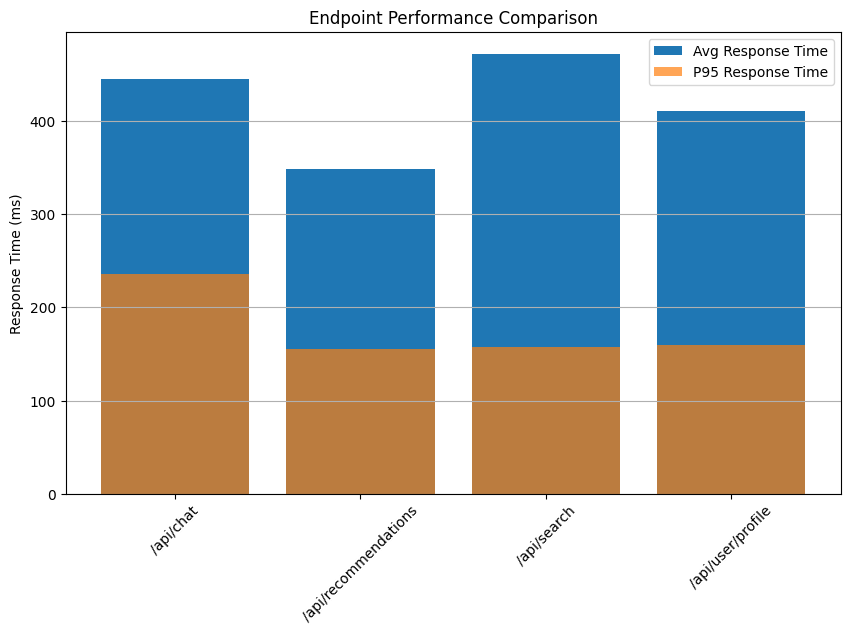

In [54]:
# Endpoint Performance Comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['endpoint'], metrics_df['avg_response_time'], label='Avg Response Time')
plt.bar(metrics_df['endpoint'], metrics_df['p95_response_time'], label='P95 Response Time', alpha=0.7)
plt.title('Endpoint Performance Comparison')
plt.ylabel('Response Time (ms)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

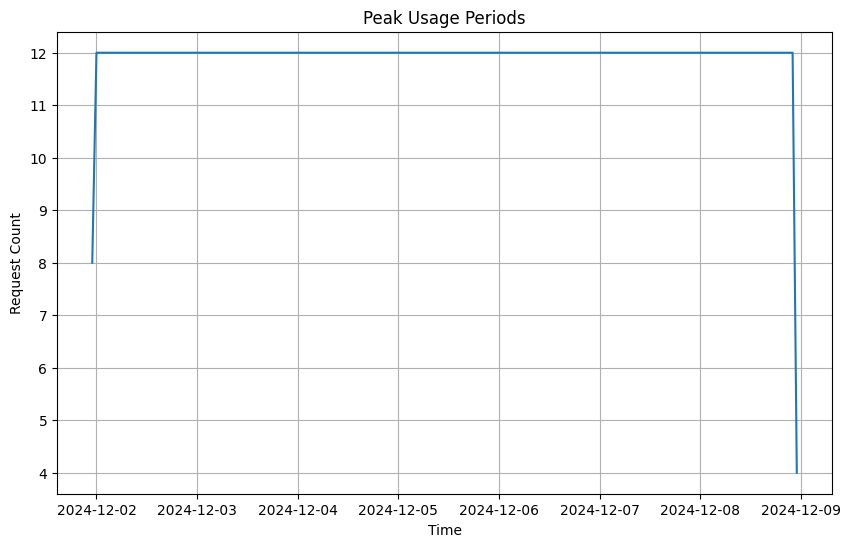

In [55]:
# Peak Usage Periods
plt.figure(figsize=(10, 6))
plt.plot(usage_by_time['timestamp'], usage_by_time['request_count'])
plt.title('Peak Usage Periods')
plt.xlabel('Time')
plt.ylabel('Request Count')
plt.grid(True)
plt.show()

# Section 3 Anomaly Detection

In [56]:
# 3. Anomaly Detection
# Response Time Anomalies
app_logs_df['zscore_response_time'] = zscore(app_logs_df['response_time_ms'])
response_time_anomalies = app_logs_df[app_logs_df['zscore_response_time'].abs() > 3]

# Error Rate Anomalies
error_rate_anomalies = metrics_df[metrics_df['error_rate'] > (metrics_df['error_rate'].mean() + 3 * metrics_df['error_rate'].std())]


# Display anomalies (optional)
print("Response Time Anomalies:")
print(response_time_anomalies)

print("Error Rate Anomalies:")
print(error_rate_anomalies)


Response Time Anomalies:
               timestamp              endpoint  user_id  response_time_ms  \
33   2024-12-02 02:05:31     /api/user/profile  user_18             30000   
139  2024-12-02 10:55:31             /api/chat   user_6             30000   
142  2024-12-02 11:10:31  /api/recommendations  user_54             30000   
184  2024-12-02 14:40:31             /api/chat  user_88             30000   
219  2024-12-02 17:35:31           /api/search  user_40             30000   
360  2024-12-03 05:20:31  /api/recommendations  user_38             30000   
514  2024-12-03 18:10:31     /api/user/profile  user_53             30000   
744  2024-12-04 13:20:31           /api/search  user_82             30000   
863  2024-12-04 23:15:31     /api/user/profile  user_13             30000   
925  2024-12-05 04:25:31           /api/search  user_18             30000   
926  2024-12-05 04:30:31             /api/chat  user_67             30000   
1022 2024-12-05 12:30:31     /api/user/profile  use

In [57]:
# Endpoint Availability Anomalies
hourly_endpoint_requests = app_logs_df.groupby(['endpoint', pd.Grouper(key='timestamp', freq='1H')]).size().reset_index(name='request_count')
availability_anomalies = hourly_endpoint_requests[hourly_endpoint_requests['request_count'] == 0]

print("Endpoint Availability Anomalies:")
print(availability_anomalies)

Endpoint Availability Anomalies:
Empty DataFrame
Columns: [endpoint, timestamp, request_count]
Index: []


<ipython-input-57-a21a36b6da92>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_endpoint_requests = app_logs_df.groupby(['endpoint', pd.Grouper(key='timestamp', freq='1H')]).size().reset_index(name='request_count')
